# **`ChemVATS`: Chemical Variational Autoencoder using Transformers for SELFIES**
formerly *Encoding and Decoding Molecules using Transformers*

Misael Andre D. Maningo | Dr. Miguel Francisco M Remolona

## A. Imports
Imports and installs to Google Colab.

In [64]:
!pip install selfies
import selfies as sf

In [65]:
!pip install rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import Image, display

In [80]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Dropout, GlobalAveragePooling1D, Layer, Lambda, Add
from tensorflow.keras.models import Model, Sequential
from keras import backend as K

import random
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

In [67]:
!pip install keras-nlp --upgrade
from keras_nlp.layers import TransformerEncoder, TransformerDecoder, SinePositionEncoding

Output wrapping in Google Colab.

In [68]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

## B. Database

### B.1. Sample ZINC Database (250k)

In [69]:
data_url = "https://github.com/aspuru-guzik-group/selfies/raw/16a489afa70882428bc194b2b24a2d33573f1651/examples/vae_example/datasets/dataJ_250k_rndm_zinc_drugs_clean.txt"
data_SMILES = pd.read_csv(data_url)
print("Total data size", len(data_SMILES))

Total data size 249455


In [ ]:
# with open('/content/drive/MyDrive/Colab Notebooks/Models/master_SELFIES.txt', 'w') as file:
#     for item in master_SELFIES:
#         file.write(f"{item}\n")

In [7]:
master_SELFIES = []
with open('/content/drive/MyDrive/Colab Notebooks/Models/master_SELFIES.txt', 'r') as file:
    for line in file:
        master_SELFIES.append(line.strip())

max_length = len(max(master_SELFIES,key=len))

In [ ]:
# master_SELFIES = [sf.encoder(s) for s in data_SMILES.iloc[0:len(data_SMILES)-1, 0]]

### B.2. ZINC API

In [ ]:
import requests
import os

In [ ]:
zinc_api_url = "https://zinc.docking.org/substances.json"

params = {
    "property_names": "smiles",
    "count": 1000,  # Number of compounds to retrieve
    "order_by": "popularity",
    "output_format": "json",
}

In [ ]:
response = requests.get(zinc_api_url, params=params)
data = response.json()

if response.status_code == 200:
    data_SMILES = [compound["smiles"] for compound in data]
else:
    print("Failed to retrieve data from ZINC.")
    data_SMILES = []

In [ ]:
output_file = "/content/drive/MyDrive/Colab Notebooks/Models/ZINCRequest_SMILES.txt"

with open(output_file, "w") as file:
    for smiles in data_SMILES:
        file.write(smiles + "\n")

print(f"SMILES strings saved to {output_file}")

SMILES strings saved to /content/drive/MyDrive/Colab Notebooks/Models/ZINCRequest_SMILES.txt


## C. Data Preprocessing

### C.1. Data Splitting
Splits data into training/validation/test sets. Also determines length of padding needed.

In [94]:
TRAIN_SIZE = 10_000
VALIDATION_SIZE = 1_000
TEST_SIZE = 5_000

train_SELFIES = master_SELFIES[0:TRAIN_SIZE]
validation_SELFIES = master_SELFIES[TRAIN_SIZE+1:TRAIN_SIZE+VALIDATION_SIZE+1]
test_SELFIES = master_SELFIES[TRAIN_SIZE+VALIDATION_SIZE+2:TRAIN_SIZE+VALIDATION_SIZE+TEST_SIZE+2]

### C.2. SELFIES Encoding

Lists all unique symbols from master data set and makes a look-up table.

In [95]:
alphabet = sf.get_alphabet_from_selfies(master_SELFIES)
alphabet = list(sorted(alphabet))  # ['[=O]', '[C]', '[F]', '[O]', '[nop]']
alphabet.insert(0, "[nop]") # [nop] is a special padding symbol. Placed at position 0
vocab_size = len(alphabet)

symbol_to_idx = {s: i for i, s in enumerate(alphabet)}
idx_to_symbol = {v: k for k, v in symbol_to_idx.items()}

Converts to integer (label) encoding.

In [96]:
train_set = []
validation_set = []
test_set = []

for x in range(TRAIN_SIZE):
    train_set.append(sf.selfies_to_encoding(
        selfies = train_SELFIES[x],
        vocab_stoi = symbol_to_idx,
        pad_to_len = max_length,
        enc_type = "label"
    ))

for x in range(VALIDATION_SIZE):
    validation_set.append(sf.selfies_to_encoding(
        selfies = validation_SELFIES[x],
        vocab_stoi = symbol_to_idx,
        pad_to_len = max_length,
        enc_type = "label"
    ))

for x in range(TEST_SIZE):
    test_set.append(sf.selfies_to_encoding(
        selfies = test_SELFIES[x],
        vocab_stoi = symbol_to_idx,
        pad_to_len = max_length,
        enc_type = "label"
    ))

# Convert python list to numpy array.
train_set = np.array(train_set)
validation_set = np.array(validation_set)
test_set = np.array(test_set)

Checking occurences for each token.

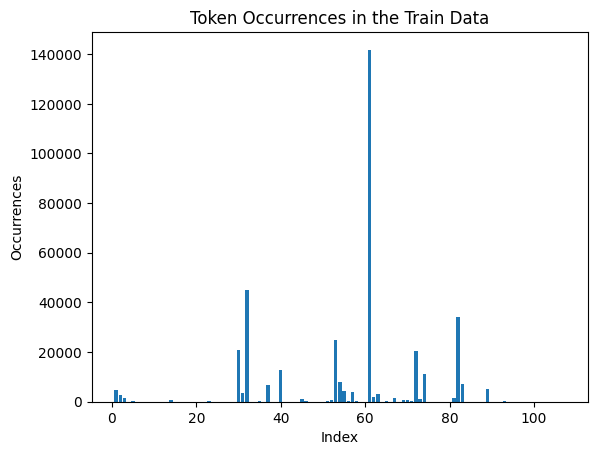

{'[C]': 141808, '[=C]': 45018, '[Ring1]': 34274, '[Branch1]': 25003, '[=Branch1]': 20939, '[N]': 20427, '[=O]': 12817, '[O]': 11336, '[Branch2]': 8077, '[Ring2]': 7197, '[=N]': 6575, '[S]': 5217, '[#Branch1]': 4551, '[C@@H1]': 4183, '[C@H1]': 4109, '[=Branch2]': 3382, '[F]': 3232, '[#Branch2]': 2696, '[Cl]': 1768, '[#C]': 1525, '[NH1+1]': 1364, '[P]': 1332, '[=Ring1]': 1056, '[O-1]': 919, '[/C]': 857, '[NH1]': 750, '[NH2+1]': 699, '[Br]': 494, '[#N]': 433, '[N+1]': 416, '[NH3+1]': 307, '[C@]': 293, '[=S]': 259, '[C@@]': 245, '[=Ring2]': 229, '[/N]': 172, '[=NH1+1]': 165, '[\\C]': 133, '[N-1]': 65, '[=N+1]': 60, '[S@@]': 41, '[\\N]': 40, '[S@]': 36, '[\\S]': 35, '[/S]': 34, '[I]': 33, '[/NH1+1]': 23, '[S-1]': 17, '[/O]': 14, '[\\O]': 14, '[=NH2+1]': 11, '[\\O-1]': 10, '[/O-1]': 3, '[/C@H1]': 2, '[=S@]': 2, '[/S-1]': 1, '[\\Cl]': 1, '[=P]': 1, '[/F]': 1, '[=OH1+1]': 1, '[\\S-1]': 1, '[=S@@]': 1, '[/C@@H1]': 1, '[\\C@@H1]': 1, '[/S@]': 1, '[/Cl]': 1, '[=N-1]': 1, '[/N+1]': 1, '[NH1-1]': 1

In [161]:
#@title {vertical-output: true}
token_array = train_set.flatten()

token_counts = {}
for number in token_array:
    if number != 0:
        if number in token_counts:
            token_counts[number] += 1
        else:
            token_counts[number] = 1


numbers = list(token_counts.keys())
occurrences = list(token_counts.values())

plt.bar(numbers, occurrences, align='center')
plt.xlabel('Index')
plt.ylabel('Occurrences')
plt.title('Token Occurrences in the Train Data')
plt.show()

token_counts = {idx_to_symbol[key]: value for key, value in token_counts.items()}
token_counts = {k: v for k, v in sorted(token_counts.items(), key=lambda item: item[1], reverse=True)}
print(token_counts)

## C. Custom Class and Methods

In [13]:
@keras.saving.register_keras_serializable('TokenAndPositionPackage')
class TokenAndPositionEmbedding(Layer):
    # adapted from https://machinelearningmastery.com/the-transformer-positional-encoding-layer-in-keras-part-2/
    def __init__(self, sequence_length, vocab_size, output_dim, name):
        # super().__init__()
        super(TokenAndPositionEmbedding, self).__init__(name=name)
        position_embedding_matrix = self.get_position_encoding(sequence_length, output_dim)
        self.word_embedding_layer = Embedding(
            input_dim=vocab_size, output_dim=output_dim,
            input_length=sequence_length,
            # weights=[word_embedding_matrix],
            trainable=True
        )
        self.position_embedding_layer = Embedding(
            input_dim=sequence_length, output_dim=output_dim,
            weights=[position_embedding_matrix],
            trainable=False
        )

    def get_position_encoding(self, seq_len, d, n=10000):
        P = np.zeros((seq_len, d))
        for k in range(seq_len):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                P[k, 2*i] = np.sin(k/denominator)
                P[k, 2*i+1] = np.cos(k/denominator)
        return P

    def call(self, inputs):
        position_indices = tf.range(tf.shape(inputs)[-1])
        embedded_words = self.word_embedding_layer(inputs)
        embedded_indices = self.position_embedding_layer(position_indices)
        return embedded_words + embedded_indices

In [37]:
def sampling(args):
    """Sampling from latent distribution."""
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], max_length, latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_var) * epsilon

In [55]:
beta = K.variable(1)

class vae_loss(keras.losses.Loss):
    def __init__(self):
        super().__init__()

    def call(self, x, x_decoded_mean):
        reconstruction_loss = keras.losses.sparse_categorical_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return reconstruction_loss + (beta) * kl_loss

## E. Building

### E.1. Model

$e^{\pi i} + 1 = 0$

In [125]:
#@title {vertical-output: true}
embed_dim = 64  # Embedding size for each token
num_heads = 6  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
latent_dim = 8 # Dimensions of latent reperesentation


encoder_input = Input((max_length,), dtype='int32', name='EncoderInput')
embedding = Embedding(
    input_dim=vocab_size,
    output_dim=embed_dim,
    input_length=max_length,
    trainable=True,
    mask_zero=True,
    name='TokenEmbedding')(encoder_input)
positional_encoding = SinePositionEncoding(name='PositionEmbedding')(embedding)
x = Add(name='EmbAddPos')([embedding, positional_encoding])
# x = TransformerEncoder(
#     intermediate_dim=ff_dim,
#     num_heads=num_heads,
#     dropout=0,
#     name='TransformerEncoder')(x)
x = Dense(64, name='TransformerDense')(x) # "Transformer" Dense
z_mean = Dense(latent_dim, name='DenseMean')(x)
z_log_var = Dense(latent_dim, name='DenseLogVar')(x)
z = Lambda(sampling, name='LatentDense')([z_mean, z_log_var])
encoder = Model(encoder_input, [z_mean, z_log_var, z], name="Encoder")

decoder_input = Input((max_length,latent_dim,), name='DecoderInput')
output = Dense(50, activation='relu', name='DecoderDense')(decoder_input)
output = Dense(vocab_size, activation='softmax', name='FinalDense')(output)
decoder = Model(decoder_input, output, name="Decoder")

vae_output = decoder(encoder(encoder_input)[2])
vae = Model(encoder_input, vae_output, name="ChemVATS")

reconstruction_loss = keras.losses.sparse_categorical_crossentropy(encoder_input, vae_output)
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
beta = K.variable(1)
# vae_loss = K.mean(reconstruction_loss + beta * kl_loss)
vae_loss = reconstruction_loss + beta * kl_loss
vae.add_loss(vae_loss)

vae.compile(
    optimizer = 'adam',
    # loss = vae_loss,
    metrics=['sparse_categorical_accuracy'],
)

vae.summary(
    expand_nested=True,
    layer_range=["Encoder", "Decoder"]
)

Model: "ChemVATS"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 EncoderInput (InputLayer)   [(None, 404)]                0         []                            
                                                                                                  
 Encoder (Functional)        [(None, 404, 8),             12112     ['EncoderInput[0][0]']        
                              (None, 404, 8),                                                     
                              (None, 404, 8)]                                                     
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| EncoderInput (InputLayer)  [(None, 404)]                0         []                           |
|                                                                                          

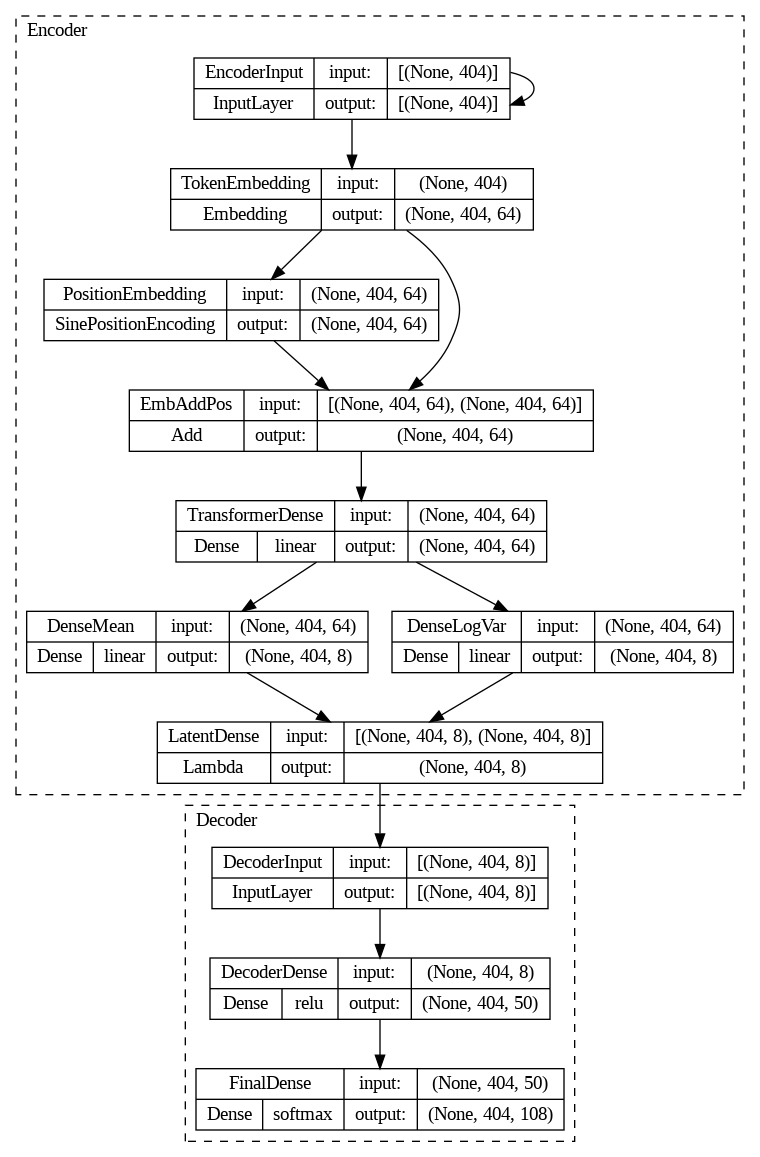

In [137]:
keras.utils.plot_model(
    vae,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=["Encoder", "Decoder"],
    show_layer_activations=True,
)

### E.2. Training and Testing

#### Callbacks
Checkpoint weight saving and Early Stop.

In [24]:
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath = '/content/drive/MyDrive/Colab Notebooks/Models/weightsCheckpoint.hdf5', #weights.{epoch:02d}-{val_loss:.2f}.hdf5'
    save_weights_only = True,
    monitor = 'val_loss', #'val_sparse_categorical_accuracy'
    mode = 'min',
    save_best_only=True
)

early_stop = keras.callbacks.EarlyStopping(
  monitor = 'val_loss',
  mode = 'min',
  patience = 4,
  min_delta = 0.0001,
  verbose = True
)

KL Annealing

In [63]:
class AnnealingCallback(keras.callbacks.Callback):
    def __init__(self, schedule, variable):
        super(AnnealingCallback, self).__init__()
        self.schedule = schedule
        self.variable = variable

    def on_epoch_begin(self, epoch, logs={}):
        value = self.schedule(epoch)
        assert type(value) == float, (
            'The output of the "schedule" function should be float.')
        K.set_value(self.variable, value)

def anneal_schedule(epoch):
    return min(epoch * 0.1, 1.)

#### Fit

In [99]:
EPOCHS = 10
BATCH_SIZE = 32    # Change `BATCH_SIZE` (ex. 100 or 128) to something large when using a GPU. When using CPU use around 32. :)

for i in range(len(vae.weights)):
    vae.weights[i]._handle_name = vae.weights[i].name + "_" + str(i)

history = vae.fit(
    x = train_set,
    y = train_set,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    shuffle = True,
    validation_data = [validation_set, validation_set],
    callbacks = [
        checkpoint,
        early_stop,
        AnnealingCallback(anneal_schedule, beta),
    ],
)

Beta =  0.0
Epoch 1/10
313/313 [==============================] - 37s 112ms/step - loss: 1.9424 - sparse_categorical_accuracy: 0.8499 - val_loss: 0.4241 - val_sparse_categorical_accuracy: 0.9533
Beta =  0.1
Epoch 2/10
313/313 [==============================] - 32s 101ms/step - loss: 0.2787 - sparse_categorical_accuracy: 0.9688 - val_loss: 0.1827 - val_sparse_categorical_accuracy: 0.9819
Beta =  0.2
Epoch 3/10
313/313 [==============================] - 32s 101ms/step - loss: 0.1361 - sparse_categorical_accuracy: 0.9869 - val_loss: 0.1017 - val_sparse_categorical_accuracy: 0.9909
Beta =  0.30000000000000004
Epoch 4/10
313/313 [==============================] - 31s 100ms/step - loss: 0.0837 - sparse_categorical_accuracy: 0.9936 - val_loss: 0.0692 - val_sparse_categorical_accuracy: 0.9955
Beta =  0.4
Epoch 5/10
313/313 [==============================] - 30s 95ms/step - loss: 0.0609 - sparse_categorical_accuracy: 0.9962 - val_loss: 0.0540 - val_sparse_categorical_accuracy: 0.9965
Beta =  0.

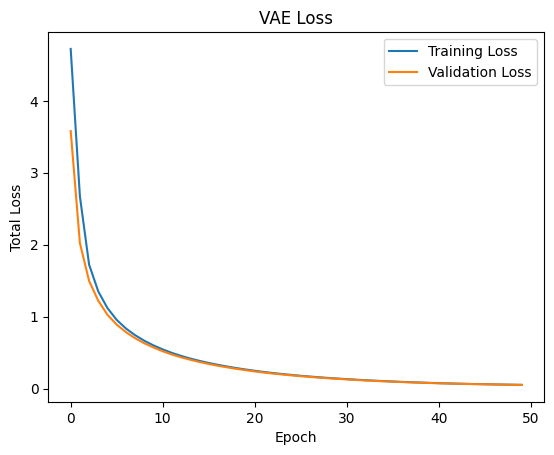

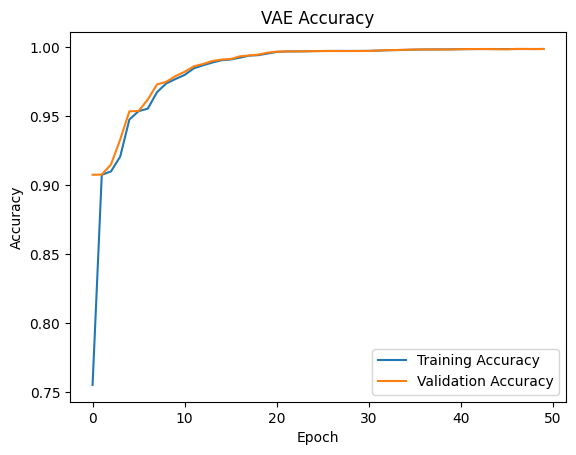

In [ ]:
#@title {vertical-output: true}
# Total Loss Plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VAE Loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

# Accuracy Plot
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('VAE Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

## E. Test

### Evaluate Loss and Accuracy on Test Set

In [128]:
vae.evaluate(
    x = test_set,
    y = test_set
)

157/157 [==============================] - 10s 63ms/step - loss: 0.0317 - sparse_categorical_accuracy: 0.9982


[0.03167816624045372, 0.9982450604438782]

### Position Comparison

In [100]:
#@title {vertical-output: true}
for pos in range(1,50):
    my_list = vae.predict([test_set[5].tolist()],verbose=0)[0][pos-1]
    print("Pos",pos,":",test_set[5][pos-1]," vs. ",np.argmax(my_list))

Pos 1 : 61  vs.  61
Pos 2 : 74  vs.  74
Pos 3 : 61  vs.  61
Pos 4 : 32  vs.  32
Pos 5 : 61  vs.  61
Pos 6 : 32  vs.  32
Pos 7 : 61  vs.  61
Pos 8 : 32  vs.  32
Pos 9 : 82  vs.  82
Pos 10 : 30  vs.  30
Pos 11 : 61  vs.  61
Pos 12 : 67  vs.  67
Pos 13 : 53  vs.  53
Pos 14 : 61  vs.  61
Pos 15 : 61  vs.  61
Pos 16 : 55  vs.  55
Pos 17 : 53  vs.  53
Pos 18 : 61  vs.  61
Pos 19 : 61  vs.  61
Pos 20 : 61  vs.  61
Pos 21 : 32  vs.  32
Pos 22 : 61  vs.  61
Pos 23 : 32  vs.  32
Pos 24 : 53  vs.  53
Pos 25 : 30  vs.  30
Pos 26 : 61  vs.  61
Pos 27 : 30  vs.  30
Pos 28 : 61  vs.  61
Pos 29 : 40  vs.  40
Pos 30 : 73  vs.  73
Pos 31 : 74  vs.  74
Pos 32 : 82  vs.  82
Pos 33 : 54  vs.  54
Pos 34 : 0  vs.  0
Pos 35 : 0  vs.  0
Pos 36 : 0  vs.  0
Pos 37 : 0  vs.  0
Pos 38 : 0  vs.  0
Pos 39 : 0  vs.  0
Pos 40 : 0  vs.  0
Pos 41 : 0  vs.  0
Pos 42 : 0  vs.  0
Pos 43 : 0  vs.  0
Pos 44 : 0  vs.  0
Pos 45 : 0  vs.  0
Pos 46 : 0  vs.  0
Pos 47 : 0  vs.  0
Pos 48 : 0  vs.  0
Pos 49 : 0  vs.  0


### Generate Latent Vector and Reconstruct Figure

Latent Vector:
 [[[ 0.3744496  -0.09743191  0.07014769 ...  0.02557057  0.15855089
   -0.43437535]
  [-0.72798723 -0.14226118  0.12952748 ... -0.1680848  -0.05470616
    0.06544544]
  [-0.2583073  -0.24012187 -0.34224597 ...  0.06891294  0.31015775
   -0.07164519]
  ...
  [-0.04093942 -0.00342596 -0.06495194 ...  0.08076864  0.10654525
   -0.03229588]
  [ 0.09464368  0.15786026 -0.09730432 ...  0.00942989  0.04904953
   -0.21414047]
  [-0.02763393  0.06496675  0.0405657  ... -0.14512347  0.15507692
    0.16971564]]] 

Original SMILES:      C[C@H](CO)[C@H](C)Nc1nc(-c2cnccn2)nc2sc3c(c12)CCCC3
Reconstructed SMILES: C[C@H1](CO)[C@H1](C)NC1=NC(C2=CN=CC=N2)=NC=3SC4=C(C1=3)CCCC4
Orig.png


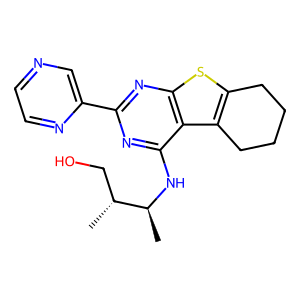

Re.png


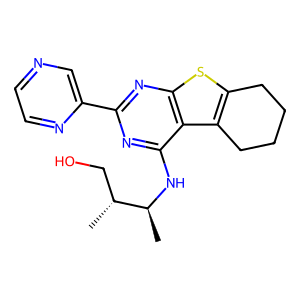

In [132]:
#@title {vertical-output: true}
extraInfo = False
dataMode = 2 # 1 for train-data ONLY, 2 for ALL data, 3 for custom

if dataMode == 1:
    test = data_SMILES.iloc[random.randint(50_000,60_000),0]
elif dataMode == 2:
    test = data_SMILES.iloc[random.randint(1, len(data_SMILES)-1),0]
elif dataMode == 3:
    test = 'CCc(c1)ccc2[n+]1ccc3c2[nH]c4c3cccc4CCc1c[n+]2ccc3c4ccccc4[nH]c3c2cc1'
test_i = test
if extraInfo: print("SMILES:", test)
test = sf.encoder(test)
if extraInfo: print("SELFIES", test)
test = sf.selfies_to_encoding(
        selfies = test,
        vocab_stoi = symbol_to_idx,
        pad_to_len = max_length,
        enc_type = "label"
    )
if extraInfo: print("SELFIES Encoding:", test)
latent_vector = encoder.predict([test],verbose=0)[2]
print("Latent Vector:\n", latent_vector, "\n")
test = vae.predict([test],verbose=0)[0]
if extraInfo: print("Recreated Input:", test)
if extraInfo: print("Recreated Input from Latent Vector:", decoder.predict([latent_vector.tolist()]))
test = np.argmax(test, axis=1)
test = sf.encoding_to_selfies(
    encoding = test,
    vocab_itos = idx_to_symbol,
    enc_type = "label"
)
if extraInfo: print("Reconstructed SELFIES:", test)
test = sf.decoder(test)
print("Original SMILES:     ", test_i)
print("Reconstructed SMILES:", test)
Draw.MolToFile(Chem.MolFromSmiles(test_i),'Orig.png')
# Image('Orig.png')
Draw.MolToFile(Chem.MolFromSmiles(test),'Re.png')

listOfImageNames = ['Orig.png',
                    'Re.png']

for imageName in listOfImageNames:
    print(imageName);display(Image(filename=imageName, width=300))

### Interpolate

CCC=1C=CSC=1NN=C(CCl)O


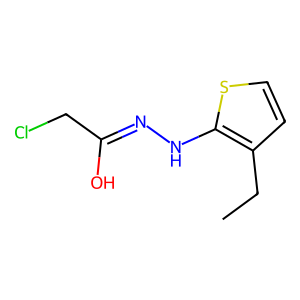

CCC=1C=CSC=1C2=NN=C(CCl)O2


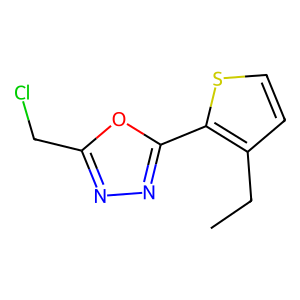

CCC=1C=CSC=1C2=NN=C(CCl)O2


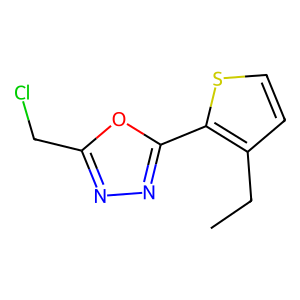

CCC=1C=CSC=1C2=NN=C(CCl)O2


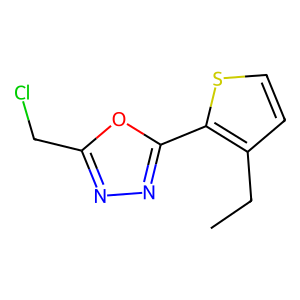

C=1CC=CS=1C2=NN=C(CCl)O2


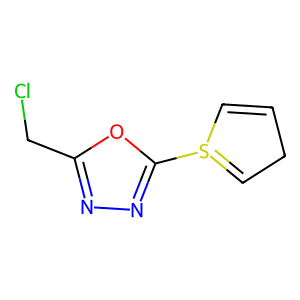

C=1CC=C=1


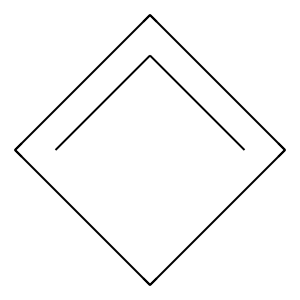

C1CC=C1C2C=C2N(C)C


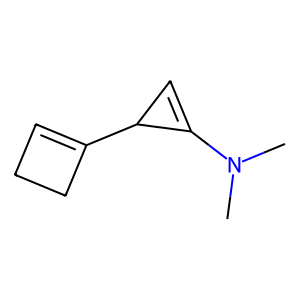

C1CC=CC1C=CCN(C)CC=O


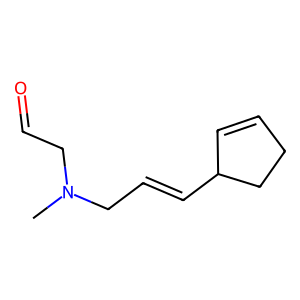

CC1=CC=CC=C1C2=CC(N(C)C(=O)C3=N[NH1]C(=O)[NH1]3)=N[NH1]2


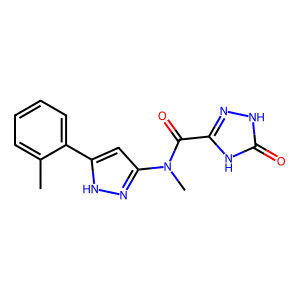

CC1=CC=CC=C1C2=CC(N(C)C(=O)C3=N[NH1]C(=O)[NH1]3)=N[NH1]2


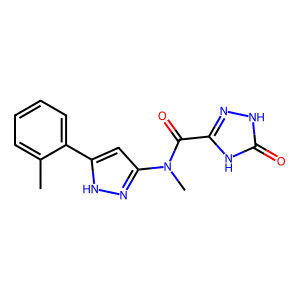

CC1=CC=CC=C1C2=CC(N(C)C(=O)C3=N[NH1]C(=O)[NH1]3)=N[NH1]2


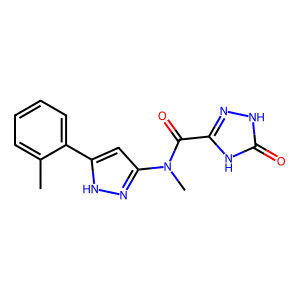

CC1=CC=CC=C1C2=CC(N(C)C(=O)C3=N[NH1]C(=O)[NH1]3)=N[NH1]2


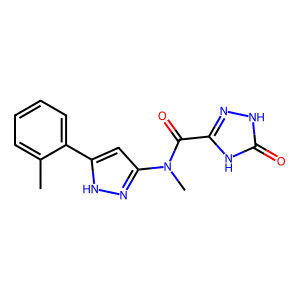

In [114]:
#@title {vertical-output: true}
mode = 1
num_steps = 10

if mode == 1:
    initial = [test_set[random.randint(0,999)].tolist()]
    final = [test_set[random.randint(0,999)].tolist()]
elif mode == 2:
    initial = 'CC'
    final = 'CCCCCCCCCCC'

    initial = sf.encoder(initial)
    initial = sf.selfies_to_encoding(
        selfies = initial,
        vocab_stoi = symbol_to_idx,
        pad_to_len = max_length,
        enc_type = "label"
    )
    initial = [initial]

    final = sf.encoder(final)
    final = sf.selfies_to_encoding(
        selfies = final,
        vocab_stoi = symbol_to_idx,
        pad_to_len = max_length,
        enc_type = "label"
    )
    final = [final]


z_mean1, z_log_var1, z1 = encoder.predict(initial,verbose=0)
z_mean2, z_log_var2, z2 = encoder.predict(final,verbose=0)

interpolated_latent_points = []
for i in range(num_steps):
    alpha = i / (num_steps - 1)  # Interpolation coefficient
    interpolated_latent_point = (1 - alpha) * z_mean1 + alpha * z_mean2
    interpolated_latent_points.append(interpolated_latent_point)
interpolated_data_points = decoder.predict(np.squeeze(np.array(interpolated_latent_points)),verbose=0)


# DECODING and Graphing -----------------
initial = np.squeeze(decoder.predict(z1,verbose=0))
test = np.argmax(initial, axis=1)
# print(test[0:20])
test = sf.encoding_to_selfies(
    encoding = test,
    vocab_itos = idx_to_symbol,
    enc_type = "label"
)
test = sf.decoder(test)
print(test)
Draw.MolToFile(Chem.MolFromSmiles(test),"Interpolation_I.png")
display(Image(filename="Interpolation_I.png", width=150))

for i in range(num_steps):
    test = interpolated_data_points[i]
    test = np.argmax(test, axis=1)
    # print(test[0:20])
    test = sf.encoding_to_selfies(
        encoding = test,
        vocab_itos = idx_to_symbol,
        enc_type = "label"
    )
    test = sf.decoder(test)
    print(test)
    file_name = f"Interpolation_{i}.png"
    Draw.MolToFile(Chem.MolFromSmiles(test),file_name)
    display(Image(filename=file_name, width=100))

final = np.squeeze(decoder.predict(z2,verbose=0))
test = np.argmax(final, axis=1)
# print(test[0:20])
test = sf.encoding_to_selfies(
    encoding = test,
    vocab_itos = idx_to_symbol,
    enc_type = "label"
)
test = sf.decoder(test)
print(test)
Draw.MolToFile(Chem.MolFromSmiles(test),"Interpolation_F.png")
display(Image(filename="Interpolation_F.png", width=150))

### Graphing Latent Space

157/157 [==============================] - 3s 17ms/step


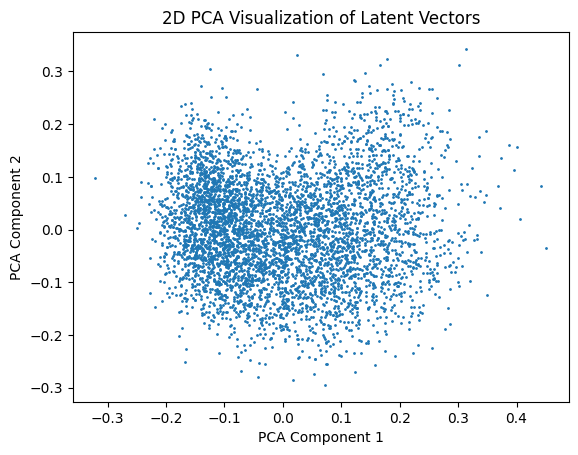

In [118]:
#@title {vertical-output: true}
from sklearn.decomposition import PCA

latent_vectors = np.mean(encoder.predict(test_set)[2],axis=2)
# latent_vectors = encoder.predict(test_set)[2].reshape(TEST_SIZE, max_length*latent_dim)
pca = PCA(n_components=2)
latent_vectors_2d = pca.fit_transform(latent_vectors)
plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], s=1)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA Visualization of Latent Vectors')
plt.show()

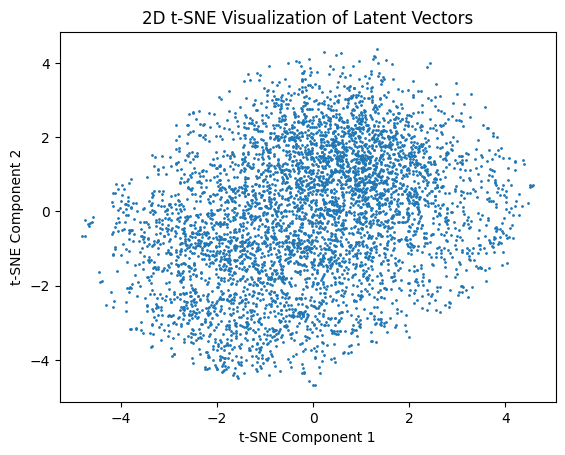

In [120]:
#@title {vertical-output: true}
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
latent_vectors_2d_tsne = tsne.fit_transform(latent_vectors)
plt.scatter(latent_vectors_2d_tsne[:, 0], latent_vectors_2d_tsne[:, 1], s=1)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('2D t-SNE Visualization of Latent Vectors')
plt.show()

### Using Learned Embedding on another Neural Network

## F. Saving Model

Save Model and Custom Layers

In [121]:
vae.save('/content/drive/MyDrive/Colab Notebooks/Models/ChemVATS.keras')

Save Final weights.

In [124]:
vae.save_weights("/content/drive/MyDrive/Colab Notebooks/Models/ChemVATS_weights.h5")

Load Model and Custom Layers

In [129]:
vae = keras.models.load_model(
    '/content/drive/MyDrive/Colab Notebooks/Models/ChemVATS.keras',
    custom_objects={
        # "TransformerPackage": TransformerBlock,
        # "TokenAndPositionPackage": TokenAndPositionEmbedding
    },
    safe_mode=False
)

ValueError: ignored

Load Final Saved Weight

In [127]:
vae.load_weights('/content/drive/MyDrive/Colab Notebooks/Models/ChemVATS_weights.h5')

Loading Checkpoint Weights

In [85]:
vae.load_weights('/content/drive/MyDrive/Colab Notebooks/Models/weightsCheckpoint.hdf5')

# OTHERS

In [ ]:
# Avoids scroll-in-the-scroll in the entire Notebook
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

In [ ]:
model = Sequential([Embedding(input_dim=5+1, output_dim=2, input_length=5), Flatten()])
model.compile('rmsprop', 'mse')
model.predict(tf.constant([[1,2,3,4,5],[5,5,5,5,5]]))

1/1 [==============================] - 0s 177ms/step


array([[-0.00806739, -0.02008803, -0.00773904, -0.00908155,  0.02701206,
        -0.03173574,  0.01688141,  0.02214426, -0.02796904,  0.00033376],
       [-0.02796904,  0.00033376, -0.02796904,  0.00033376, -0.02796904,
         0.00033376, -0.02796904,  0.00033376, -0.02796904,  0.00033376]],
      dtype=float32)